Update: use NLTK to preprocess text data

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd
import nltk as nk
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics
from pprint import pprint
from copy import deepcopy

from Semi_EM_NB import Semi_EM_MultinomialNB
from time import time
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
# Load train and test data set with class labels 
train_Xy = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_Xy = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [3]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [4]:
# preprocess train and test text data
train_Xy.data_clean = map(remove_noise, train_Xy.data)
test_Xy.data_clean = map(remove_noise, test_Xy.data)

In [5]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_Xy.data_clean)
test_vec = vectorizer.transform(test_Xy.data_clean)
print train_vec.shape, test_vec.shape

(11314, 11282) (7532, 11282)


In [6]:
# Divide train data set into labeled and unlabeled data sets
n_train_data = train_vec.shape[0]
split_ratio = 0.2 # labeled vs total(labeled+unlabeled)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_Xy.target, train_size=split_ratio, stratify=train_Xy.target)
print X_l.shape, X_u.shape

(2262, 11282) (9052, 11282)


In [7]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_accuracies= list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        train_accuracies.append(metrics.accuracy_score(valid_y, pred))
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % np.mean(np.array(train_accuracies)))
    return train_accuracies, train_time

In [8]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_clf = MultinomialNB(alpha=1e-2)
cross_validation(nb_clf, X_l, y_l)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.072 seconds
Average training accuracy: 0.660


([0.66013071895424835,
  0.66301969365426694,
  0.643956043956044,
  0.66592427616926508,
  0.66515837104072395],
 0.07211899757385254)

In [9]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2) # semi supervised EM based Naive Bayes classifier
cross_validation(em_nb_clf, X_l, y_l, X_u)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Initial expected log likelihood = -3916530.470

EM iteration #1
	Expected log likelihood = -3666914.797
EM iteration #2
	Expected log likelihood = -3665222.145
EM iteration #3
	Expected log likelihood = -3664996.156
EM iteration #4
	Expected log likelihood = -3664860.251
EM iteration #5
	Expected log likelihood = -3664835.750
EM iteration #6
	Expected log likelihood = -3664827.811
EM iteration #7
	Expected log likelihood = -3664827.811
Fold # 2
Initial expected log likelihood = -3913966.662

EM iteration #1
	Expected log likelihood = -3666103.638
EM iteration #2
	Expected log likelihood = -3664372.307
EM iteration #3
	Expected log likelihood = -3664241.022
EM iteration #4
	Expected log likelihood = -3664231.524
EM iteration #5
	Expected log likelihood = -3664231.524
Fold # 3
Initial expected log likelihood = -3921097.586

EM iteration #1
	Expected log likelihood = -3671681.326
EM iteration #2
	Expected lo

([0.66448801742919394,
  0.69365426695842447,
  0.70549450549450554,
  0.68596881959910916,
  0.67194570135746612],
 78.83219695091248)

In [10]:
# Evaluate original NB classifier using test data set
nb_clf = MultinomialNB(alpha=1e-2).fit(X_l, y_l)
pred = nb_clf.predict(test_vec)
print(metrics.classification_report(test_Xy.target, pred, target_names=test_Xy.target_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_Xy.target, pred))

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.39      0.44       319
           comp.graphics       0.58      0.57      0.57       389
 comp.os.ms-windows.misc       0.53      0.44      0.48       394
comp.sys.ibm.pc.hardware       0.49      0.58      0.53       392
   comp.sys.mac.hardware       0.60      0.56      0.58       385
          comp.windows.x       0.63      0.73      0.68       395
            misc.forsale       0.67      0.62      0.64       390
               rec.autos       0.67      0.58      0.62       396
         rec.motorcycles       0.70      0.66      0.68       398
      rec.sport.baseball       0.88      0.76      0.81       397
        rec.sport.hockey       0.57      0.89      0.70       399
               sci.crypt       0.65      0.71      0.68       396
         sci.electronics       0.56      0.44      0.49       393
                 sci.med       0.73      0.69      0.71       396
         

In [11]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2).fit(X_l, y_l, X_u)
pred = em_nb_clf.predict(test_vec)
print(metrics.classification_report(test_Xy.target, pred, target_names=test_Xy.target_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_Xy.target, pred))

Initial expected log likelihood = -3891925.747

EM iteration #1
	Expected log likelihood = -3666454.814
EM iteration #2
	Expected log likelihood = -3664989.087
EM iteration #3
	Expected log likelihood = -3664831.139
EM iteration #4
	Expected log likelihood = -3664808.132
EM iteration #5
	Expected log likelihood = -3664795.673
EM iteration #6
	Expected log likelihood = -3664795.673
                          precision    recall  f1-score   support

             alt.atheism       0.60      0.33      0.43       319
           comp.graphics       0.56      0.62      0.59       389
 comp.os.ms-windows.misc       0.55      0.41      0.47       394
comp.sys.ibm.pc.hardware       0.50      0.63      0.56       392
   comp.sys.mac.hardware       0.63      0.55      0.59       385
          comp.windows.x       0.68      0.75      0.71       395
            misc.forsale       0.74      0.57      0.64       390
               rec.autos       0.72      0.66      0.69       396
         rec.motorcyc

In [15]:
# find the most informative features 
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
%matplotlib inline
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    fig, axes = plt.subplots(figsize=(50, 40), nrows=5, ncols=4)
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud().generate(text)
        axes[i//4, i%4].imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
        axes[i//4, i%4].axis("off")
        axes[i//4, i%4].set_title(category, fontweight="bold", size=24)
    plt.show()

alt.atheism: kill doe moral think religion thi exist atheist say god
comp.graphics: thank know program use file thi graphic color imag ani
comp.os.ms-windows.misc: ftp ani thank problem thi card use driver file window
comp.sys.ibm.pc.hardware: thank pc use ani mb dx monitor scsi card drive
comp.sys.mac.hardware: mb card simm use thi problem modem drive mac appl
comp.windows.x: widget xterm thank program display run use thi motif window
misc.forsale: includ condit use new sell pleas email price offer sale
rec.autos: make engin think like ford ani buy thi wa car
rec.motorcycles: know like motorcycl dog thi helmet wa dod ride bike
rec.sport.baseball: think thi win score year team run pitch hit game
rec.sport.hockey: year nhl playoff hockey wa player season team play game
sci.crypt: privaci govern use bite nsa chip clipper thi encrypt key
sci.electronics: know radar power pin grind circuit like work thi use
sci.med: edu patient geb gordon wa know msg ha food thi
sci.space: shuttl flight mo

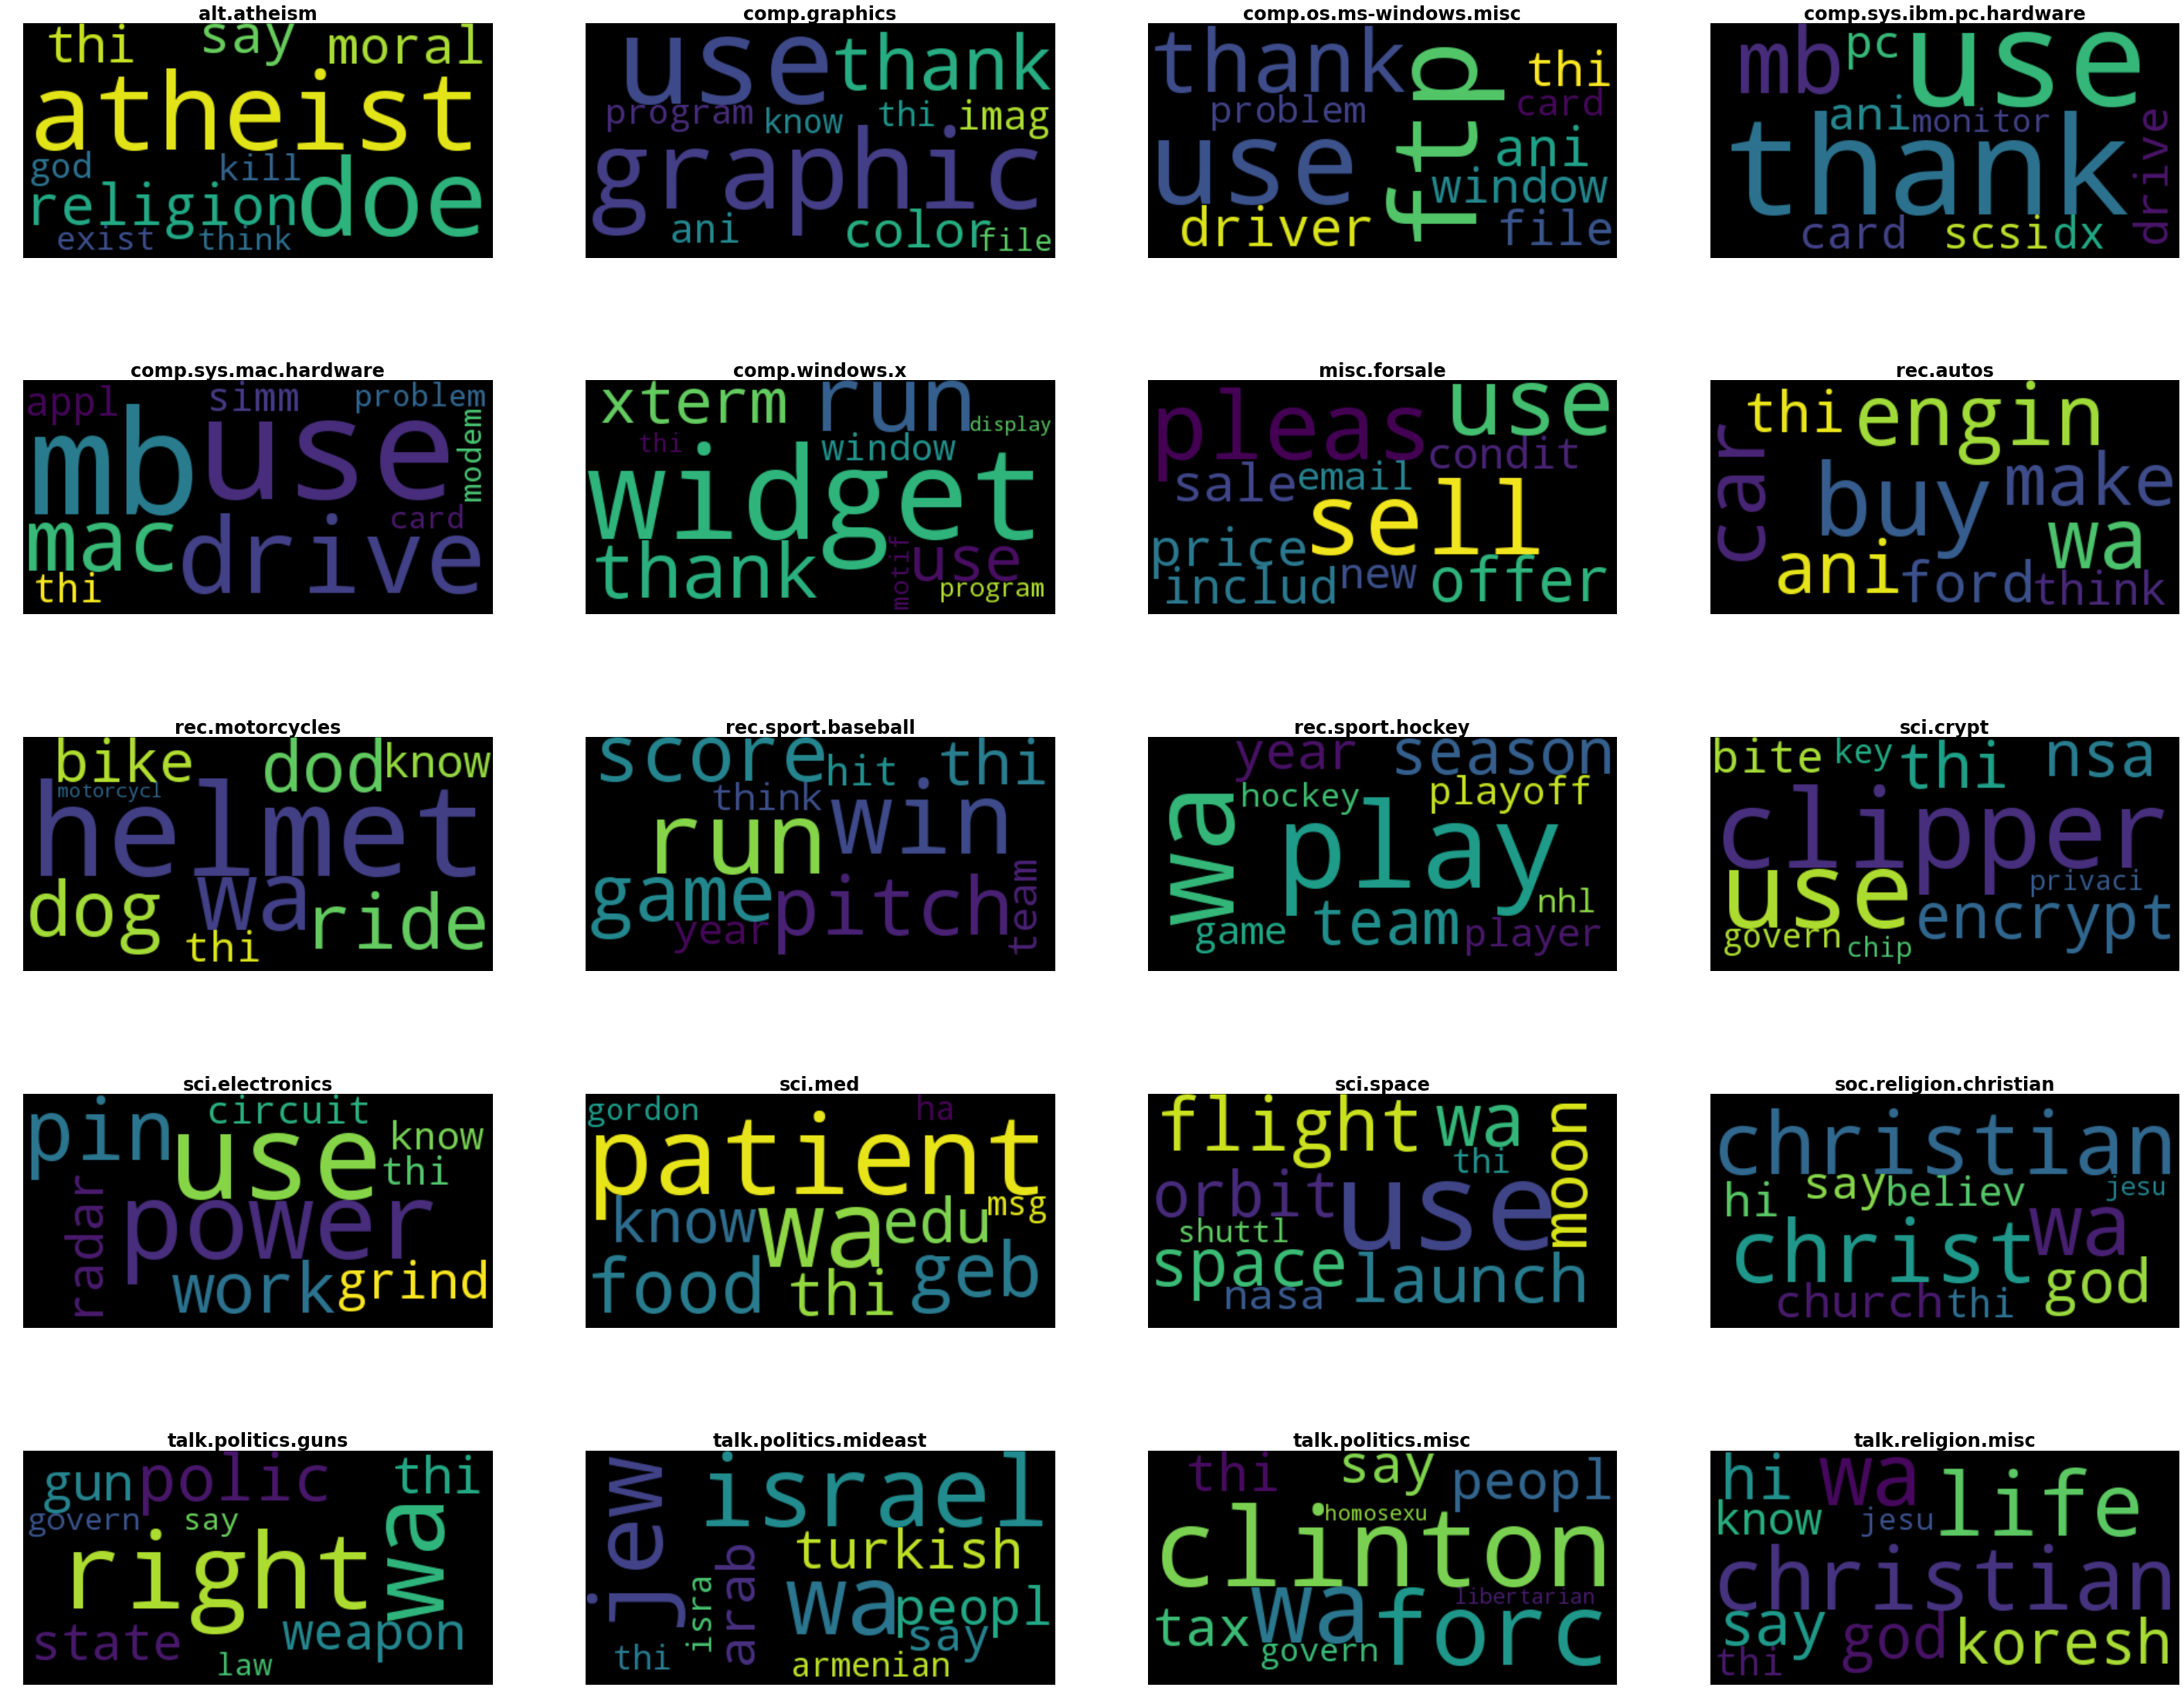

In [16]:
show_topK(nb_clf, vectorizer, train_Xy.target_names, K=10) # keywords for each class by original NB classifier

alt.atheism: islam peopl exist think atheist object thi say moral god
comp.graphics: anyon know use thi program ani imag graphic thank file
comp.os.ms-windows.misc: printer card program ftp thank thi use driver file window
comp.sys.ibm.pc.hardware: ani ide bu thi use monitor mb scsi card drive
comp.sys.mac.hardware: ani problem card modem use thi simm drive appl mac
comp.windows.x: ani applic program run widget motif server thi use window
misc.forsale: new pleas email includ price condit sell ship offer sale
rec.autos: new look buy ani like drive engin thi wa car
rec.motorcycles: dog think like helmet thi motorcycl dod wa ride bike
rec.sport.baseball: thi win hi hit player wa pitch team year game
rec.sport.hockey: nhl playoff thi season player hockey wa play team game
sci.crypt: escrow phone govern use secur clipper chip thi encrypt key
sci.electronics: know ani chip work amp power like circuit thi use
sci.med: pitt doctor gordon patient geb wa diseas food msg thi
sci.space: year think

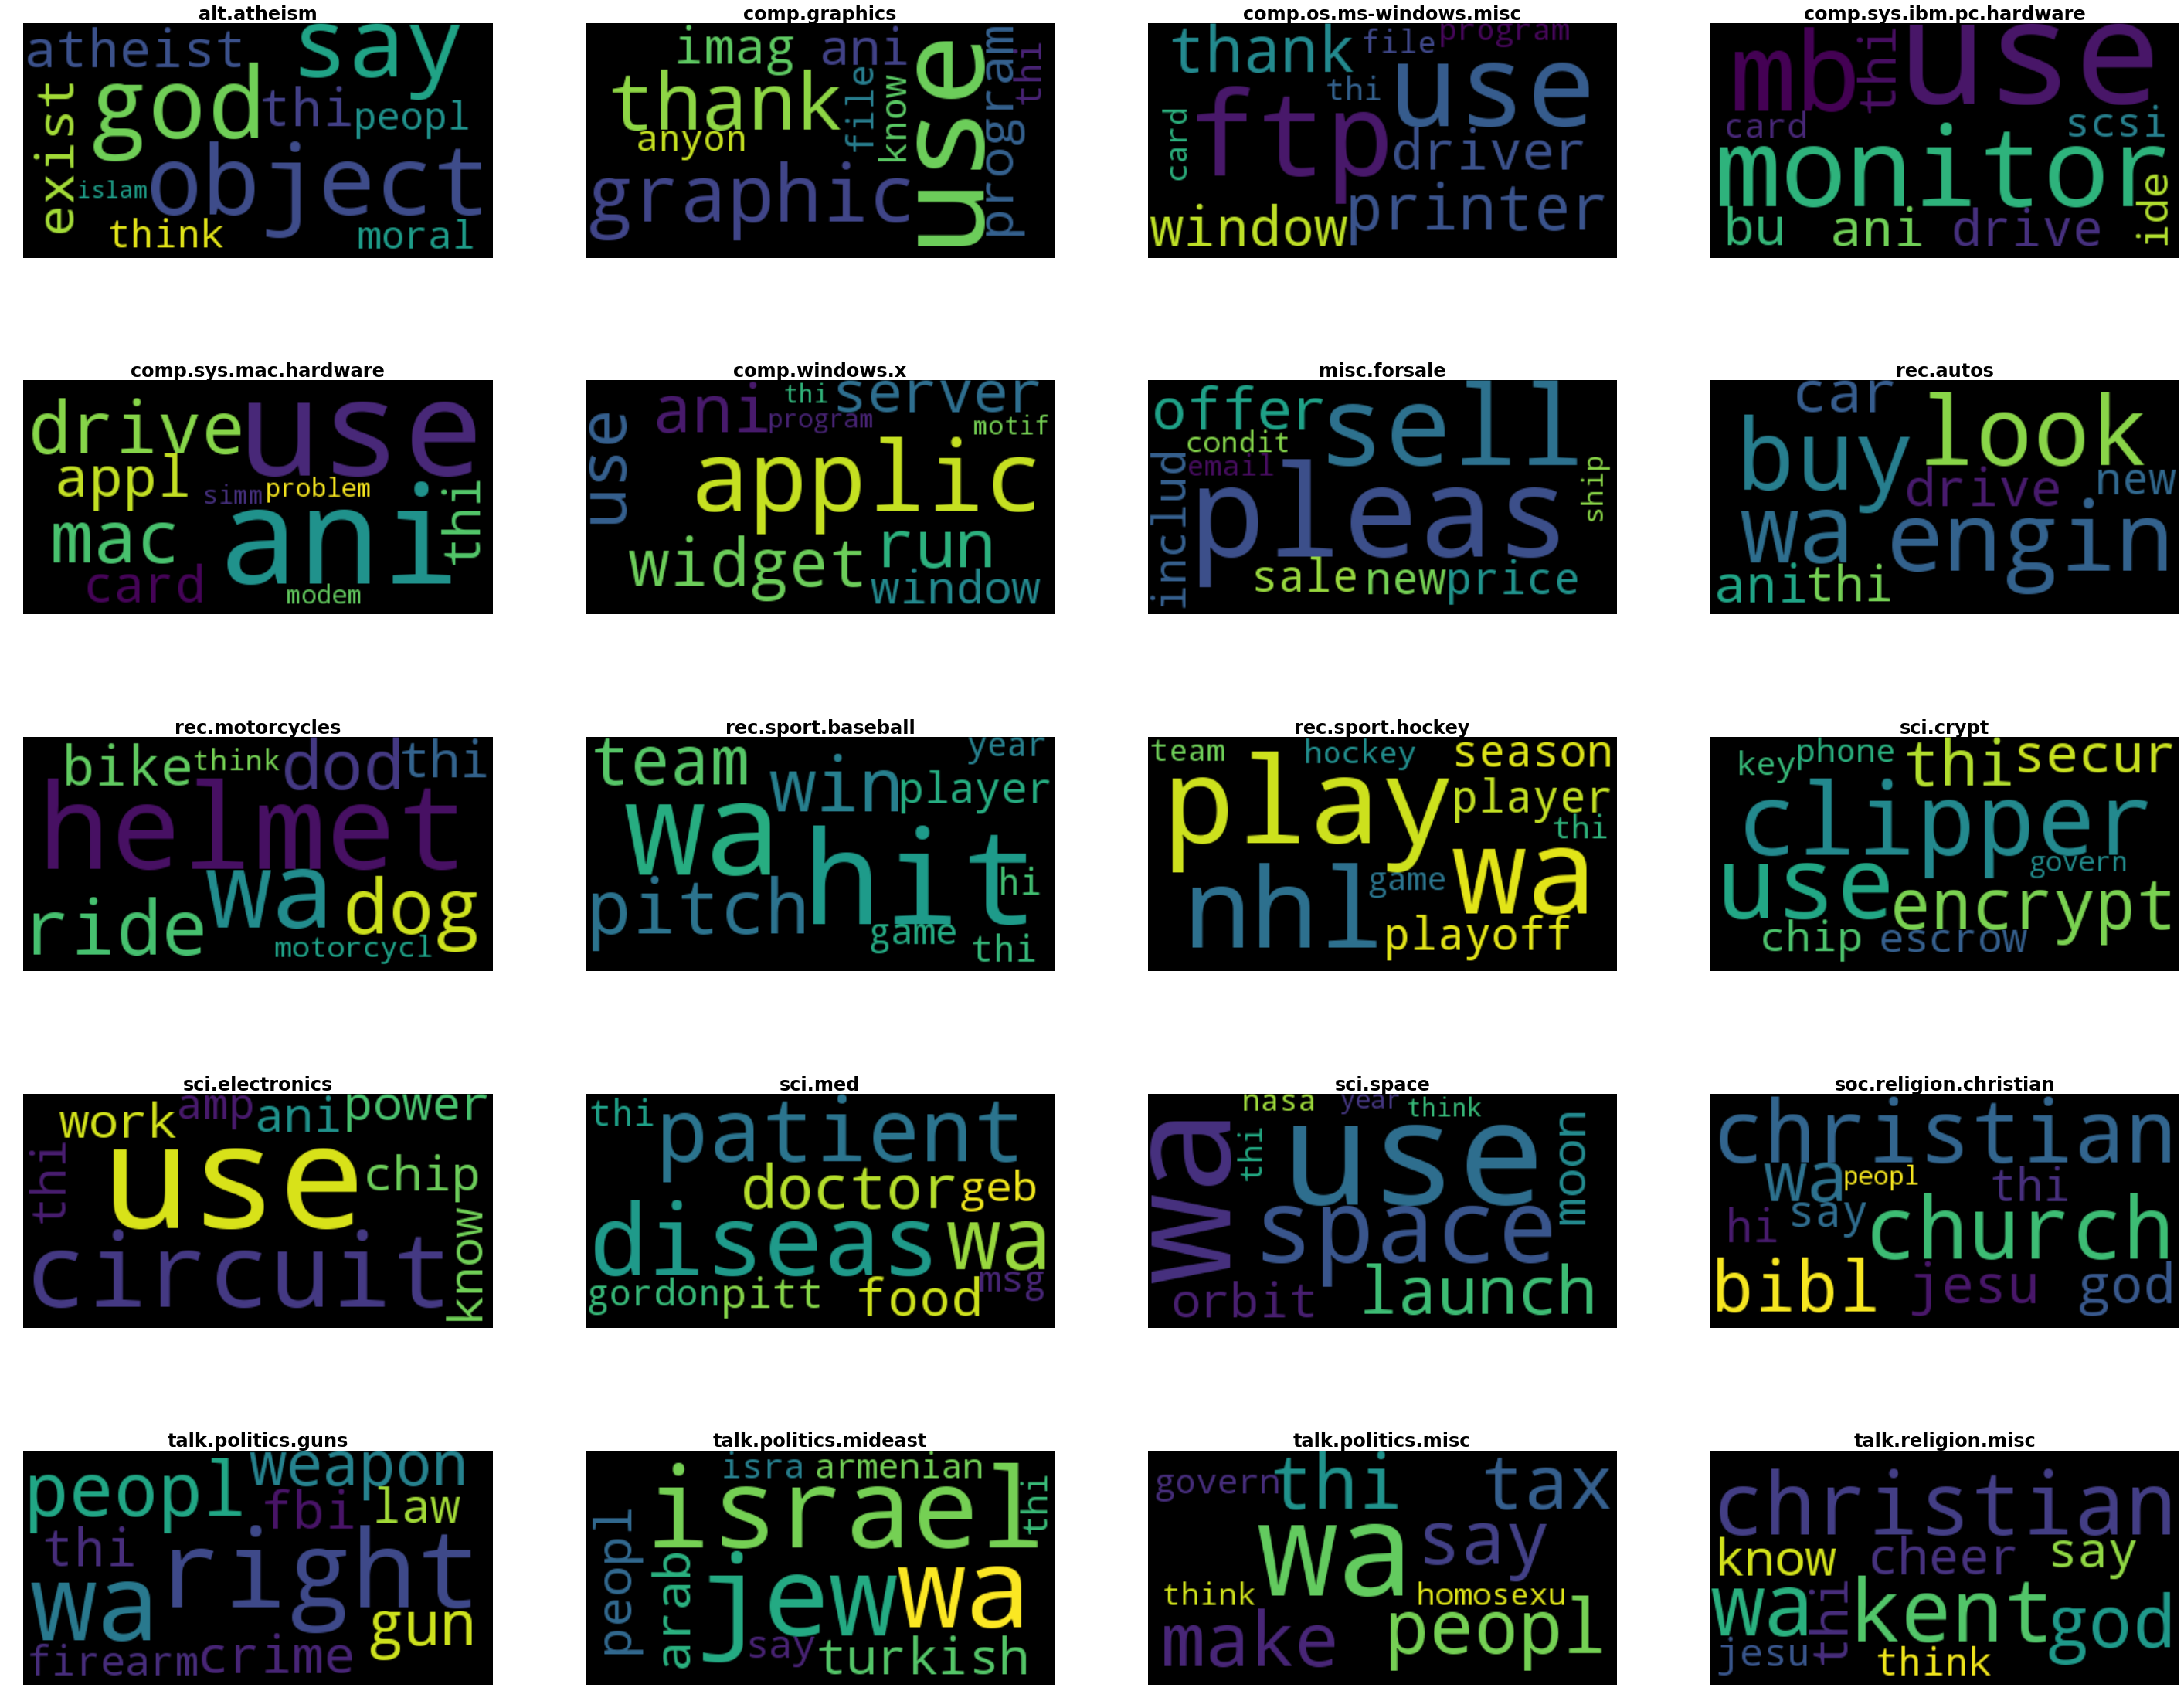

In [17]:
show_topK(em_nb_clf, vectorizer, train_Xy.target_names, K=10) # keywords for each class by semisupervised EM NB classifier